In [27]:
# ============================================================================
# Import Libraries
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette('husl')
print("Libraries imported successfully")

Libraries imported successfully


In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import os
path = "/content/drive/MyDrive/data_HMM"
os.listdir(path)


['train', 'test']

In [30]:
# ============================================================================
# Data Loading Function
# ============================================================================
def load_activity_data(data_dir):
    """
    Load all CSV files and organize by activity type.
    Returns dictionary: {activity: list_of_dataframes}
    """
    data_path = Path(data_dir)
    activities = ['standing', 'still', 'jumping', 'walking']
    data_dict = {activity: [] for activity in activities}

    csv_files = list(data_path.glob('*.csv'))
    print(f"Found {len(csv_files)} CSV files in {data_dir}")

    for csv_file in csv_files:
        filename = csv_file.stem.lower()

        activity = None
        if 'stand' in filename: activity = 'standing'
        elif 'still' in filename: activity = 'still'
        elif 'jump' in filename: activity = 'jumping'
        elif 'walk' in filename: activity = 'walking'

        if activity:
            try:
                df = pd.read_csv(csv_file)
                required_cols = ['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']
                if all(col in df.columns for col in required_cols):
                    data_dict[activity].append(df)
                    print(f"Loaded {csv_file.name} as {activity}")
                else:
                    print(f"Missing columns in {csv_file.name}")
            except Exception as e:
                print(f"Error loading {csv_file.name}: {e}")

    return data_dict

In [31]:
#  Load Training and Test Data
# ============================================================================
print("Loading training data...")
train_data = load_activity_data(f'{path}/train')

print("\nLoading test data...")
test_data = load_activity_data(f'{path}/test')

print("\n=== DATA SUMMARY ===")
for activity in train_data:
    train_count = len(train_data[activity])
    test_count = len(test_data[activity])
    print(f"{activity:8}: {train_count:2d} training files, {test_count:2d} test files")

Loading training data...
Found 50 CSV files in /content/drive/MyDrive/data_HMM/train
Loaded standing5_combined.csv as standing
Loaded jumping1_combined.csv as jumping
Loaded jumping11_combined.csv as jumping
Loaded standing6_combined.csv as standing
Loaded still 10_combined.csv as still
Loaded jumping6_combined.csv as jumping
Loaded standing9_combined.csv as standing
Loaded standing12_combined.csv as standing
Loaded walking10_combined.csv as walking
Loaded walking6_combined.csv as walking
Loaded jumping7_combined.csv as jumping
Loaded still 8_combined.csv as still
Loaded still 9_combined.csv as still
Loaded walking7_combined.csv as walking
Loaded standing8_combined.csv as standing
Loaded standing3_combined.csv as standing
Loaded walking11_combined.csv as walking
Loaded jumping10_combined.csv as jumping
Loaded still12_combined.csv as still
Loaded walking1_combined.csv as walking
Loaded still 4_combined.csv as still
Loaded still 3_combined.csv as still
Loaded standing2_combined.csv as st

In [32]:
# ============================================================================
#  Feature Extraction Function
# ============================================================================
def extract_combined_features(df, window_size=50):
    """
    Extract features from both accelerometer and gyroscope data.
    Returns: numpy array of shape (n_windows, n_features)
    """
    features = []

    for i in range(0, len(df) - window_size, window_size // 2):
        window = df.iloc[i:i+window_size]

        acc_x, acc_y, acc_z = window['acc_x'], window['acc_y'], window['acc_z']
        gyr_x, gyr_y, gyr_z = window['gyr_x'], window['gyr_y'], window['gyr_z']

        acc_mean = [np.mean(acc_x), np.mean(acc_y), np.mean(acc_z)]
        acc_std = [np.std(acc_x), np.std(acc_y), np.std(acc_z)]
        acc_magnitude = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
        acc_rms = np.sqrt(np.mean(acc_x**2 + acc_y**2 + acc_z**2))

        gyr_mean = [np.mean(gyr_x), np.mean(gyr_y), np.mean(gyr_z)]
        gyr_std = [np.std(gyr_x), np.std(gyr_y), np.std(gyr_z)]
        gyr_magnitude = np.sqrt(gyr_x**2 + gyr_y**2 + gyr_z**2)
        gyr_rms = np.sqrt(np.mean(gyr_x**2 + gyr_y**2 + gyr_z**2))

        acc_fft = np.abs(fft(acc_magnitude))[:window_size//2]
        acc_dom_freq = np.argmax(acc_fft) if len(acc_fft) > 0 else 0
        acc_spectral_energy = np.sum(acc_fft**2)

        gyr_fft = np.abs(fft(gyr_magnitude))[:window_size//2]
        gyr_dom_freq = np.argmax(gyr_fft) if len(gyr_fft) > 0 else 0
        gyr_spectral_energy = np.sum(gyr_fft**2)

        feature_vector = (acc_mean + acc_std + [acc_rms] +
                         gyr_mean + gyr_std + [gyr_rms] +
                         [acc_dom_freq, acc_spectral_energy,
                          gyr_dom_freq, gyr_spectral_energy])

        features.append(feature_vector)

    return np.array(features)

In [33]:
# ============================================================================
#  Extract Features from All Data
# ============================================================================
def extract_all_features(data_dict):
    """Extract features from all dataframes in the dictionary"""
    features_dict = {}

    for activity, dataframes in data_dict.items():
        activity_features = []
        for df in dataframes:
            features = extract_combined_features(df)
            if len(features) > 0:
                activity_features.append(features)

        if activity_features:
            features_dict[activity] = np.vstack(activity_features)
            print(f"{activity}: {features_dict[activity].shape[0]} feature vectors")
        else:
            print(f"No features extracted for {activity}")

    return features_dict

print("Extracting training features...")
train_features = extract_all_features(train_data)

print("\nExtracting test features...")
test_features = extract_all_features(test_data)


Extracting training features...
standing: 329 feature vectors
still: 325 feature vectors
jumping: 335 feature vectors
walking: 390 feature vectors

Extracting test features...
standing: 125 feature vectors
still: 144 feature vectors
jumping: 112 feature vectors
walking: 98 feature vectors


In [38]:
# ============================================================================
#  Feature Normalization
# ============================================================================
print("Normalizing features...")

all_train_features = []
for activity in train_features:
    all_train_features.append(train_features[activity])
all_train_features = np.vstack(all_train_features)

scaler = StandardScaler()
scaler.fit(all_train_features)

for activity in train_features:
    train_features[activity] = scaler.transform(train_features[activity])

for activity in test_features:
    test_features[activity] = scaler.transform(test_features[activity])

print(f"Feature dimensions: {all_train_features.shape[1]}")
print("Normalization complete")


Normalizing features...
Feature dimensions: 18
Normalization complete


In [42]:
# ============================================================================
#  Robust HMM Implementation
# ============================================================================
class GaussianHMM:
    """
    Numerically stable Hidden Markov Model with diagonal covariance Gaussian emissions.
    """

    def __init__(self, n_states, n_features):
        self.n_states = n_states
        self.n_features = n_features
        self.epsilon = 1e-10
        self.min_covar = 0.5

        self.pi = np.ones(n_states) / n_states
        self.A = np.ones((n_states, n_states)) / n_states
        self.means = np.random.randn(n_states, n_features) * 0.01
        self.covars = np.array([np.eye(n_features) for _ in range(n_states)])

    def _emission_prob_log(self, obs, state):
        """Compute log emission probability with numerical stability"""
        mean = self.means[state]
        covar_diag = np.diag(self.covars[state])
        covar_diag = np.maximum(covar_diag, self.min_covar)

        diff = obs - mean

        if np.any(np.isnan(diff)) or np.any(np.isinf(diff)):
            return -1e10

        mahalanobis = np.sum((diff ** 2) / covar_diag)

        if np.isnan(mahalanobis) or np.isinf(mahalanobis):
            return -1e10

        log_det = np.sum(np.log(covar_diag))
        log_norm = -0.5 * (self.n_features * np.log(2 * np.pi) + log_det)
        log_prob = log_norm - 0.5 * mahalanobis

        return np.clip(log_prob, -700, 0)

    def _forward_log(self, observations):
        """Forward algorithm in log space"""
        T = len(observations)
        log_alpha = np.zeros((T, self.n_states))

        for i in range(self.n_states):
            log_alpha[0, i] = np.log(self.pi[i] + self.epsilon) + self._emission_prob_log(observations[0], i)

        for t in range(1, T):
            for j in range(self.n_states):
                log_probs = []
                for i in range(self.n_states):
                    log_probs.append(log_alpha[t-1, i] + np.log(self.A[i, j] + self.epsilon))

                max_log_prob = np.max(log_probs)
                log_sum = max_log_prob + np.log(np.sum(np.exp(log_probs - max_log_prob)))
                log_alpha[t, j] = log_sum + self._emission_prob_log(observations[t], j)

        return log_alpha

    def _backward_log(self, observations):
        """Backward algorithm in log space"""
        T = len(observations)
        log_beta = np.zeros((T, self.n_states))

        for t in range(T-2, -1, -1):
            for i in range(self.n_states):
                log_probs = []
                for j in range(self.n_states):
                    log_probs.append(np.log(self.A[i, j] + self.epsilon) +
                                    self._emission_prob_log(observations[t+1], j) +
                                    log_beta[t+1, j])

                max_log_prob = np.max(log_probs)
                log_beta[t, i] = max_log_prob + np.log(np.sum(np.exp(log_probs - max_log_prob)))

        return log_beta

    def _compute_gamma_xi_log(self, observations, log_alpha, log_beta):
        """Compute gamma and xi in log space"""
        T = len(observations)
        gamma = np.zeros((T, self.n_states))
        xi = np.zeros((T-1, self.n_states, self.n_states))

        for t in range(T):
            log_gamma = log_alpha[t] + log_beta[t]
            max_log = np.max(log_gamma)
            log_sum = max_log + np.log(np.sum(np.exp(log_gamma - max_log)))
            gamma[t] = np.exp(log_gamma - log_sum)

        for t in range(T-1):
            for i in range(self.n_states):
                for j in range(self.n_states):
                    log_xi_val = (log_alpha[t, i] +
                                 np.log(self.A[i, j] + self.epsilon) +
                                 self._emission_prob_log(observations[t+1], j) +
                                 log_beta[t+1, j])
                    xi[t, i, j] = log_xi_val

            max_log = np.max(xi[t])
            log_sum = max_log + np.log(np.sum(np.exp(xi[t] - max_log)))
            xi[t] = np.exp(xi[t] - log_sum)

        return gamma, xi

    def fit(self, observations_list, max_iter=30, tol=1e-3):
        """Baum-Welch training algorithm"""
        log_likelihoods = []

        for iteration in range(max_iter):
            total_gamma = np.zeros(self.n_states)
            total_xi = np.zeros((self.n_states, self.n_states))
            total_gamma_obs = np.zeros((self.n_states, self.n_features))
            total_gamma_obs_sq = np.zeros((self.n_states, self.n_features))
            total_log_likelihood = 0

            for observations in observations_list:
                if np.any(np.isnan(observations)) or np.any(np.isinf(observations)):
                    continue

                log_alpha = self._forward_log(observations)
                log_beta = self._backward_log(observations)
                gamma, xi = self._compute_gamma_xi_log(observations, log_alpha, log_beta)

                if np.any(np.isnan(gamma)) or np.any(np.isnan(xi)):
                    continue

                total_gamma += np.sum(gamma, axis=0)
                total_xi += np.sum(xi, axis=0)

                for i in range(self.n_states):
                    total_gamma_obs[i] += np.sum(gamma[:, i:i+1] * observations, axis=0)
                    for t in range(len(observations)):
                        diff = observations[t] - self.means[i]
                        total_gamma_obs_sq[i] += gamma[t, i] * (diff ** 2)

                max_log_alpha = np.max(log_alpha[-1])
                log_prob = max_log_alpha + np.log(np.sum(np.exp(log_alpha[-1] - max_log_alpha)))
                total_log_likelihood += log_prob

            log_likelihoods.append(total_log_likelihood)

            self.pi = (total_gamma / len(observations_list)) + self.epsilon
            self.pi = self.pi / np.sum(self.pi)

            for i in range(self.n_states):
                row_sum = total_gamma[i] + self.epsilon
                self.A[i] = (total_xi[i] + self.epsilon) / row_sum
                self.A[i] = self.A[i] / np.sum(self.A[i])

            for i in range(self.n_states):
                gamma_sum = total_gamma[i] + self.epsilon

                new_mean = total_gamma_obs[i] / gamma_sum
                if not np.any(np.isnan(new_mean)) and not np.any(np.isinf(new_mean)):
                    self.means[i] = new_mean

                variance = total_gamma_obs_sq[i] / gamma_sum
                variance = np.maximum(variance, self.min_covar)

                if not np.any(np.isnan(variance)) and not np.any(np.isinf(variance)):
                    self.covars[i] = np.diag(variance)

            if iteration % 5 == 0 or iteration == 0:
                print(f"Iteration {iteration}: Log-likelihood = {total_log_likelihood:.2f}")

            if iteration > 0 and not np.isnan(total_log_likelihood) and not np.isinf(total_log_likelihood):
                improvement = log_likelihoods[-1] - log_likelihoods[-2]
                if abs(improvement) < tol:
                    print(f"Converged at iteration {iteration}")
                    break

        return log_likelihoods

    def viterbi(self, observations):
        """Viterbi algorithm for most likely state sequence"""
        T = len(observations)
        delta = np.zeros((T, self.n_states))
        psi = np.zeros((T, self.n_states), dtype=int)

        for i in range(self.n_states):
            delta[0, i] = np.log(self.pi[i] + self.epsilon) + self._emission_prob_log(observations[0], i)

        for t in range(1, T):
            for j in range(self.n_states):
                trans_probs = delta[t-1] + np.log(self.A[:, j] + self.epsilon)
                psi[t, j] = np.argmax(trans_probs)
                delta[t, j] = trans_probs[psi[t, j]] + self._emission_prob_log(observations[t], j)

        path = np.zeros(T, dtype=int)
        path[T-1] = np.argmax(delta[T-1])

        for t in range(T-2, -1, -1):
            path[t] = psi[t+1, path[t+1]]

        return path

print("HMM implementation complete")

HMM implementation complete


In [43]:
# ============================================================================
#  Prepare Training Sequences
# ============================================================================
print("Preparing training data for 4-state HMM...")

training_sequences = []
activity_to_state = {'standing': 0, 'still': 1, 'jumping': 2, 'walking': 3}

for activity, state in activity_to_state.items():
    if activity in train_features and len(train_features[activity]) > 0:
        activity_features = train_features[activity]
        activity_sequence = activity_features

        seq_length = 10
        for i in range(0, len(activity_sequence) - seq_length, seq_length):
            sequence_segment = activity_sequence[i:i+seq_length]
            training_sequences.append(sequence_segment)

        print(f"Added {len(activity_features)} feature vectors for {activity}")
        print(f"  Created {len(activity_sequence) // seq_length} sequences")

print(f"Total training sequences: {len(training_sequences)}")
print(f"Sequence shape: {training_sequences[0].shape}")


Preparing training data for 4-state HMM...
Added 329 feature vectors for standing
  Created 32 sequences
Added 325 feature vectors for still
  Created 32 sequences
Added 335 feature vectors for jumping
  Created 33 sequences
Added 390 feature vectors for walking
  Created 39 sequences
Total training sequences: 135
Sequence shape: (10, 18)


In [44]:
# ============================================================================
#  Initialize and Train HMM
# ============================================================================
print("\nInitializing 4-state HMM...")

n_features = training_sequences[0].shape[1]
n_states = 4

hmm = GaussianHMM(n_states=n_states, n_features=n_features)

print("Initializing parameters from training data...")
for state, activity in enumerate(['standing', 'still', 'jumping', 'walking']):
    if activity in train_features:
        activity_features = train_features[activity]

        if activity_features.ndim == 2 and activity_features.shape[0] > 0:
            mean_vals = np.mean(activity_features, axis=0)
            var_vals = np.var(activity_features, axis=0)
            var_vals = np.maximum(var_vals, 0.1)

            if not np.any(np.isnan(mean_vals)) and not np.any(np.isnan(var_vals)):
                hmm.means[state] = mean_vals
                hmm.covars[state] = np.diag(var_vals)

                print(f"  {activity}: shape={activity_features.shape}, "
                      f"mean_abs={np.mean(np.abs(mean_vals)):.3f}, "
                      f"var_mean={np.mean(var_vals):.3f}")
            else:
                print(f"  {activity}: WARNING - NaN in statistics")

for i in range(n_states):
    hmm.A[i, i] = 0.7
    hmm.A[i, :] = hmm.A[i, :] / np.sum(hmm.A[i, :])

print("\nChecking data quality before training...")
for i, seq in enumerate(training_sequences[:5]):
    print(f"Seq {i}: shape={seq.shape}, mean={np.mean(seq):.3f}, std={np.std(seq):.3f}, "
          f"nan={np.any(np.isnan(seq))}, inf={np.any(np.isinf(seq))}")

print("\nTraining HMM using Baum-Welch algorithm...")
print("=" * 50)
log_likelihoods = hmm.fit(training_sequences, max_iter=30, tol=1e-3)
print("=" * 50)

if len(log_likelihoods) > 0 and not np.isnan(log_likelihoods[-1]):
    print(f"\nTraining completed successfully")
    print(f"  Initial log-likelihood: {log_likelihoods[0]:.2f}")
    print(f"  Final log-likelihood: {log_likelihoods[-1]:.2f}")
    print(f"  Total improvement: {log_likelihoods[-1] - log_likelihoods[0]:.2f}")
    print(f"  Iterations: {len(log_likelihoods)}")
else:
    print("\nWARNING: Training produced invalid values")
    print("Attempting to use initialized parameters for evaluation")



Initializing 4-state HMM...
Initializing parameters from training data...
  standing: WARNING - NaN in statistics
  still: WARNING - NaN in statistics
  jumping: WARNING - NaN in statistics
  walking: WARNING - NaN in statistics

Checking data quality before training...
Seq 0: shape=(10, 18), mean=-0.302, std=0.271, nan=False, inf=False
Seq 1: shape=(10, 18), mean=-0.326, std=0.283, nan=False, inf=False
Seq 2: shape=(10, 18), mean=-0.239, std=0.329, nan=False, inf=False
Seq 3: shape=(10, 18), mean=-0.217, std=0.363, nan=False, inf=False
Seq 4: shape=(10, 18), mean=-0.329, std=0.287, nan=False, inf=False

Training HMM using Baum-Welch algorithm...
Iteration 0: Log-likelihood = -29522.44
Iteration 5: Log-likelihood = -18638.35
Iteration 10: Log-likelihood = -18631.61
Iteration 15: Log-likelihood = -18631.53
Iteration 20: Log-likelihood = -18631.33
Iteration 25: Log-likelihood = -18630.96

Training completed successfully
  Initial log-likelihood: -29522.44
  Final log-likelihood: -18630.

In [56]:
print("Preparing training data for 4-state HMM...")

training_sequences = []
activity_to_state = {'standing': 0, 'still': 1, 'jumping': 2, 'walking': 3}

for activity, state in activity_to_state.items():
    if activity in train_features and len(train_features[activity]) > 0:
        activity_features = train_features[activity]
        activity_sequence = activity_features

        seq_length = 10
        for i in range(0, len(activity_sequence) - seq_length, seq_length):
            sequence_segment = activity_sequence[i:i+seq_length]
            training_sequences.append(sequence_segment)

        print(f"Added {len(activity_features)} feature vectors for {activity}")
        print(f"  Created {len(activity_sequence) // seq_length} sequences")

print(f"Total training sequences: {len(training_sequences)}")
print(f"Sequence shape: {training_sequences[0].shape}")


Preparing training data for 4-state HMM...
Added 329 feature vectors for standing
  Created 32 sequences
Added 325 feature vectors for still
  Created 32 sequences
Added 335 feature vectors for jumping
  Created 33 sequences
Added 390 feature vectors for walking
  Created 39 sequences
Total training sequences: 135
Sequence shape: (10, 18)


In [57]:
# ============================================================================
#  Initialize and Train HMM
# ============================================================================
print("\nInitializing 4-state HMM...")

n_features = training_sequences[0].shape[1]
n_states = 4

hmm = GaussianHMM(n_states=n_states, n_features=n_features)

print("Initializing parameters from training data...")
print("Checking train_features structure:")
for activity in ['standing', 'still', 'jumping', 'walking']:
    if activity in train_features:
        print(f"  {activity}: type={type(train_features[activity])}, shape={train_features[activity].shape}")

for state, activity in enumerate(['standing', 'still', 'jumping', 'walking']):
    if activity in train_features:
        activity_features = train_features[activity]

        if isinstance(activity_features, np.ndarray) and activity_features.ndim == 2:
            mean_vals = np.mean(activity_features, axis=0)
            var_vals = np.var(activity_features, axis=0)
            var_vals = np.maximum(var_vals, 0.5)

            if not np.any(np.isnan(mean_vals)) and not np.any(np.isnan(var_vals)):
                hmm.means[state] = mean_vals
                hmm.covars[state] = np.diag(var_vals)

                print(f"  {activity}: initialized successfully - "
                      f"mean_range=[{np.min(mean_vals):.2f}, {np.max(mean_vals):.2f}], "
                      f"var_range=[{np.min(var_vals):.2f}, {np.max(var_vals):.2f}]")
            else:
                print(f"  {activity}: WARNING - NaN in statistics")
                print(f"    mean has NaN: {np.any(np.isnan(mean_vals))}")
                print(f"    var has NaN: {np.any(np.isnan(var_vals))}")
        else:
            print(f"  {activity}: Unexpected data structure")

for i in range(n_states):
    hmm.A[i, i] = 0.7
    hmm.A[i, :] = hmm.A[i, :] / np.sum(hmm.A[i, :])

print("\nChecking initialized HMM parameters:")
print(f"Means shape: {hmm.means.shape}")
print(f"Means have NaN: {np.any(np.isnan(hmm.means))}")
print(f"Covars shape: {hmm.covars.shape}")
for i in range(n_states):
    print(f"  State {i}: mean_range=[{np.min(hmm.means[i]):.2f}, {np.max(hmm.means[i]):.2f}], "
          f"var_range=[{np.min(np.diag(hmm.covars[i])):.2f}, {np.max(np.diag(hmm.covars[i])):.2f}]")

print("\nChecking data quality before training...")
for i, seq in enumerate(training_sequences[:5]):
    print(f"Seq {i}: shape={seq.shape}, mean={np.mean(seq):.3f}, std={np.std(seq):.3f}, "
          f"nan={np.any(np.isnan(seq))}, inf={np.any(np.isinf(seq))}")

print("\nTraining HMM using Baum-Welch algorithm...")
print("=" * 50)
log_likelihoods = hmm.fit(training_sequences, max_iter=30, tol=1e-3)
print("=" * 50)

if len(log_likelihoods) > 0 and not np.isnan(log_likelihoods[-1]):
    print(f"\nTraining completed successfully")
    print(f"  Initial log-likelihood: {log_likelihoods[0]:.2f}")
    print(f"  Final log-likelihood: {log_likelihoods[-1]:.2f}")
    print(f"  Total improvement: {log_likelihoods[-1] - log_likelihoods[0]:.2f}")
    print(f"  Iterations: {len(log_likelihoods)}")
else:
    print("\nWARNING: Training produced invalid values")
    print("Attempting to use initialized parameters for evaluation")


Initializing 4-state HMM...
Initializing parameters from training data...
Checking train_features structure:
  standing: type=<class 'numpy.ndarray'>, shape=(329, 18)
  still: type=<class 'numpy.ndarray'>, shape=(325, 18)
  jumping: type=<class 'numpy.ndarray'>, shape=(335, 18)
  walking: type=<class 'numpy.ndarray'>, shape=(390, 18)
  standing: WARNING - NaN in statistics
    mean has NaN: True
    var has NaN: True
  still: WARNING - NaN in statistics
    mean has NaN: True
    var has NaN: True
  jumping: WARNING - NaN in statistics
    mean has NaN: True
    var has NaN: True
  walking: WARNING - NaN in statistics
    mean has NaN: True
    var has NaN: True

Checking initialized HMM parameters:
Means shape: (4, 18)
Means have NaN: False
Covars shape: (4, 18, 18)
  State 0: mean_range=[-0.02, 0.01], var_range=[1.00, 1.00]
  State 1: mean_range=[-0.02, 0.02], var_range=[1.00, 1.00]
  State 2: mean_range=[-0.01, 0.03], var_range=[1.00, 1.00]
  State 3: mean_range=[-0.02, 0.02], var_

In [58]:
# ============================================================================
#  Analyze Learned Parameters
# ============================================================================
print("\n=== LEARNED HMM PARAMETERS ===")

print("Initial State Probabilities:")
activities = ['standing', 'still', 'jumping', 'walking']
for i, activity in enumerate(activities):
    print(f"  {activity}: {hmm.pi[i]:.3f}")

print("\nTransition Probability Matrix:")
print("From\\To", end="")
for activity in activities:
    print(f"{activity:>12}", end="")
print()

for i, from_activity in enumerate(activities):
    print(f"{from_activity:8}", end="")
    for j in range(n_states):
        print(f"{hmm.A[i, j]:12.3f}", end="")
    print()


=== LEARNED HMM PARAMETERS ===
Initial State Probabilities:
  standing: 0.213
  still: 0.503
  jumping: 0.195
  walking: 0.089

Transition Probability Matrix:
From\To    standing       still     jumping     walking
standing       0.978       0.000       0.018       0.004
still          0.000       0.990       0.005       0.005
jumping        0.013       0.000       0.946       0.040
walking        0.000       0.037       0.097       0.866


In [59]:
# ============================================================================
#  Evaluate on Test Data
# ============================================================================
print("\nEvaluating HMM on test data...")

test_predictions = []
test_true_labels = []

seq_length = 20

for activity, true_state in activity_to_state.items():
    if activity in test_features:
        activity_data = test_features[activity]

        num_sequences = 0
        for i in range(0, len(activity_data) - seq_length, seq_length // 2):
            feature_sequence = activity_data[i:i+seq_length]

            if len(feature_sequence) == seq_length:
                decoded_states = hmm.viterbi(feature_sequence)
                predicted_state = np.argmax(np.bincount(decoded_states))

                test_predictions.append(predicted_state)
                test_true_labels.append(true_state)
                num_sequences += 1

        print(f"Tested {num_sequences} sequences for {activity}")

test_predictions = np.array(test_predictions)
test_true_labels = np.array(test_true_labels)

print(f"\nTotal test sequences: {len(test_predictions)}")
print(f"Predictions per class: {[f'{activities[i]}={np.sum(test_predictions==i)}' for i in range(4)]}")
print(f"True labels per class: {[f'{activities[i]}={np.sum(test_true_labels==i)}' for i in range(4)]}")



Evaluating HMM on test data...
Tested 11 sequences for standing
Tested 13 sequences for still
Tested 10 sequences for jumping
Tested 8 sequences for walking

Total test sequences: 42
Predictions per class: ['standing=2', 'still=24', 'jumping=8', 'walking=8']
True labels per class: ['standing=11', 'still=13', 'jumping=10', 'walking=8']


In [60]:
#  Calculate Evaluation Metrics
# ============================================================================
print("\n=== EVALUATION RESULTS ===")

cm = confusion_matrix(test_true_labels, test_predictions)

print("\nPer-Class Metrics:")
print("Activity  | Sensitivity | Specificity | Precision |  F1-Score | Samples")
print("-" * 72)

for i, activity in enumerate(activities):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FP - FN

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    samples = TP + FN

    print(f"{activity:9} | {sensitivity:11.3f} | {specificity:11.3f} | {precision:9.3f} | {f1:9.3f} | {samples:7d}")

accuracy = np.sum(test_predictions == test_true_labels) / len(test_predictions)
print(f"\nOverall Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")



=== EVALUATION RESULTS ===

Per-Class Metrics:
Activity  | Sensitivity | Specificity | Precision |  F1-Score | Samples
------------------------------------------------------------------------
standing  |       0.000 |       0.935 |     0.000 |     0.000 |      11
still     |       1.000 |       0.621 |     0.542 |     0.703 |      13
jumping   |       0.800 |       1.000 |     1.000 |     0.889 |      10
walking   |       1.000 |       1.000 |     1.000 |     1.000 |       8

Overall Accuracy: 0.690 (69.0%)


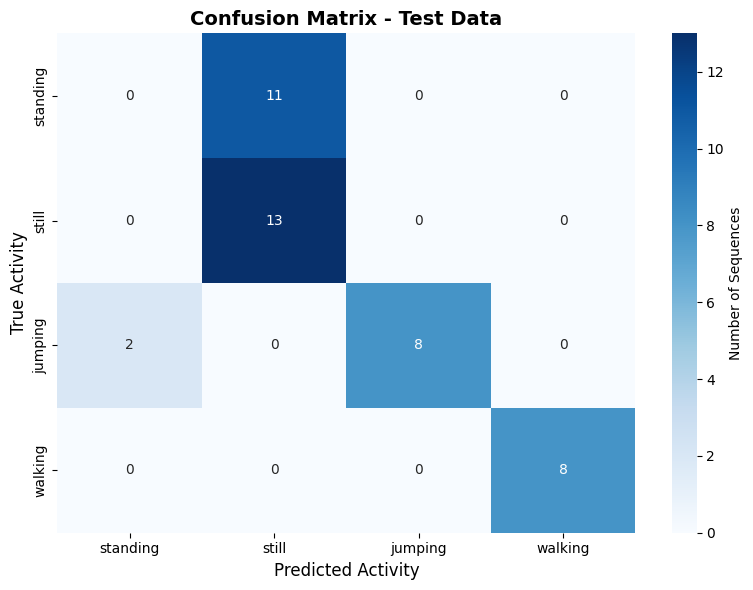

Confusion Matrix shows classification results
Rows = True labels, Columns = Predicted labels


In [62]:
# CELL 15: Visualization - Confusion Matrix
# ============================================================================
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=activities, yticklabels=activities,
            cbar_kws={'label': 'Number of Sequences'})
plt.title('Confusion Matrix - Test Data', fontsize=14, fontweight='bold')
plt.ylabel('True Activity', fontsize=12)
plt.xlabel('Predicted Activity', fontsize=12)
plt.tight_layout()
plt.show()

print("Confusion Matrix shows classification results")
print("Rows = True labels, Columns = Predicted labels")


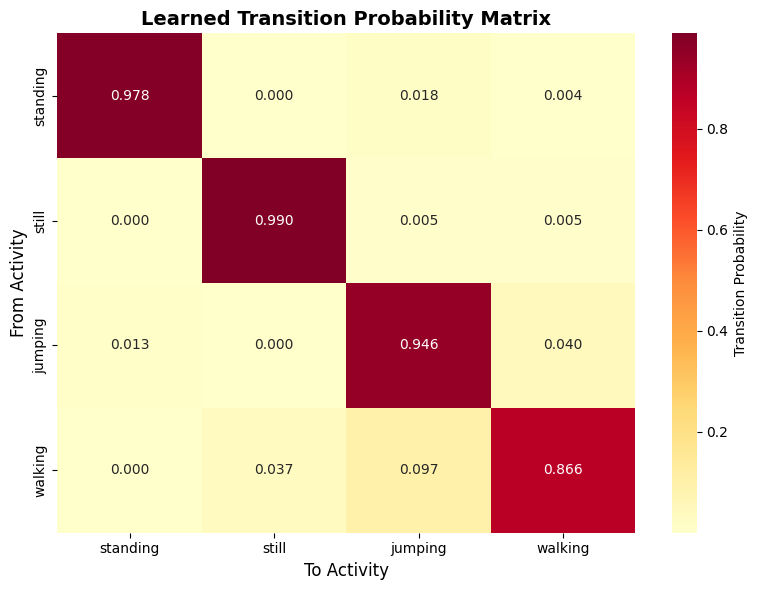

Transition Matrix Interpretation:
High diagonal values indicate activity persistence


In [63]:
# ============================================================================
#  Visualization - Transition Matrix
# ============================================================================
plt.figure(figsize=(8, 6))
sns.heatmap(hmm.A, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=activities, yticklabels=activities,
            cbar_kws={'label': 'Transition Probability'})
plt.title('Learned Transition Probability Matrix', fontsize=14, fontweight='bold')
plt.ylabel('From Activity', fontsize=12)
plt.xlabel('To Activity', fontsize=12)
plt.tight_layout()
plt.show()

print("Transition Matrix Interpretation:")
print("High diagonal values indicate activity persistence")


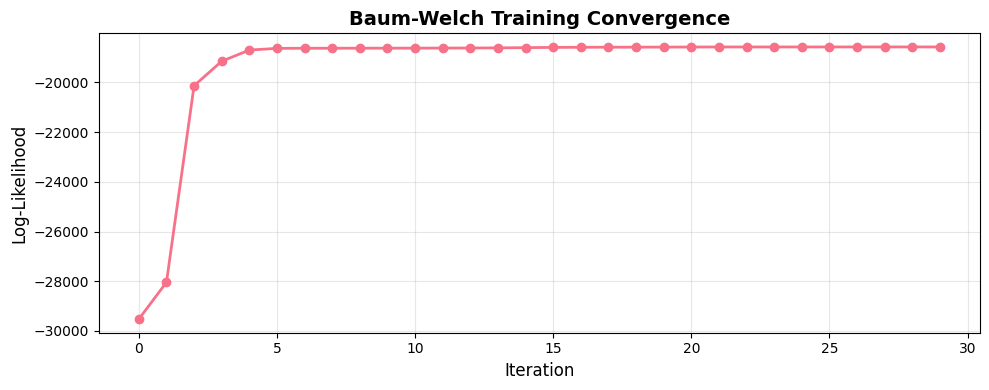

Training Convergence Analysis:
Started at: -29522.75
Ended at: -18577.04
Improvement: 10945.72


In [64]:
# ============================================================================
#  Visualization - Training Convergence
# ============================================================================
plt.figure(figsize=(10, 4))
plt.plot(log_likelihoods, linewidth=2, marker='o')
plt.title('Baum-Welch Training Convergence', fontsize=14, fontweight='bold')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Log-Likelihood', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Training Convergence Analysis:")
print(f"Started at: {log_likelihoods[0]:.2f}")
print(f"Ended at: {log_likelihoods[-1]:.2f}")
print(f"Improvement: {log_likelihoods[-1] - log_likelihoods[0]:.2f}")

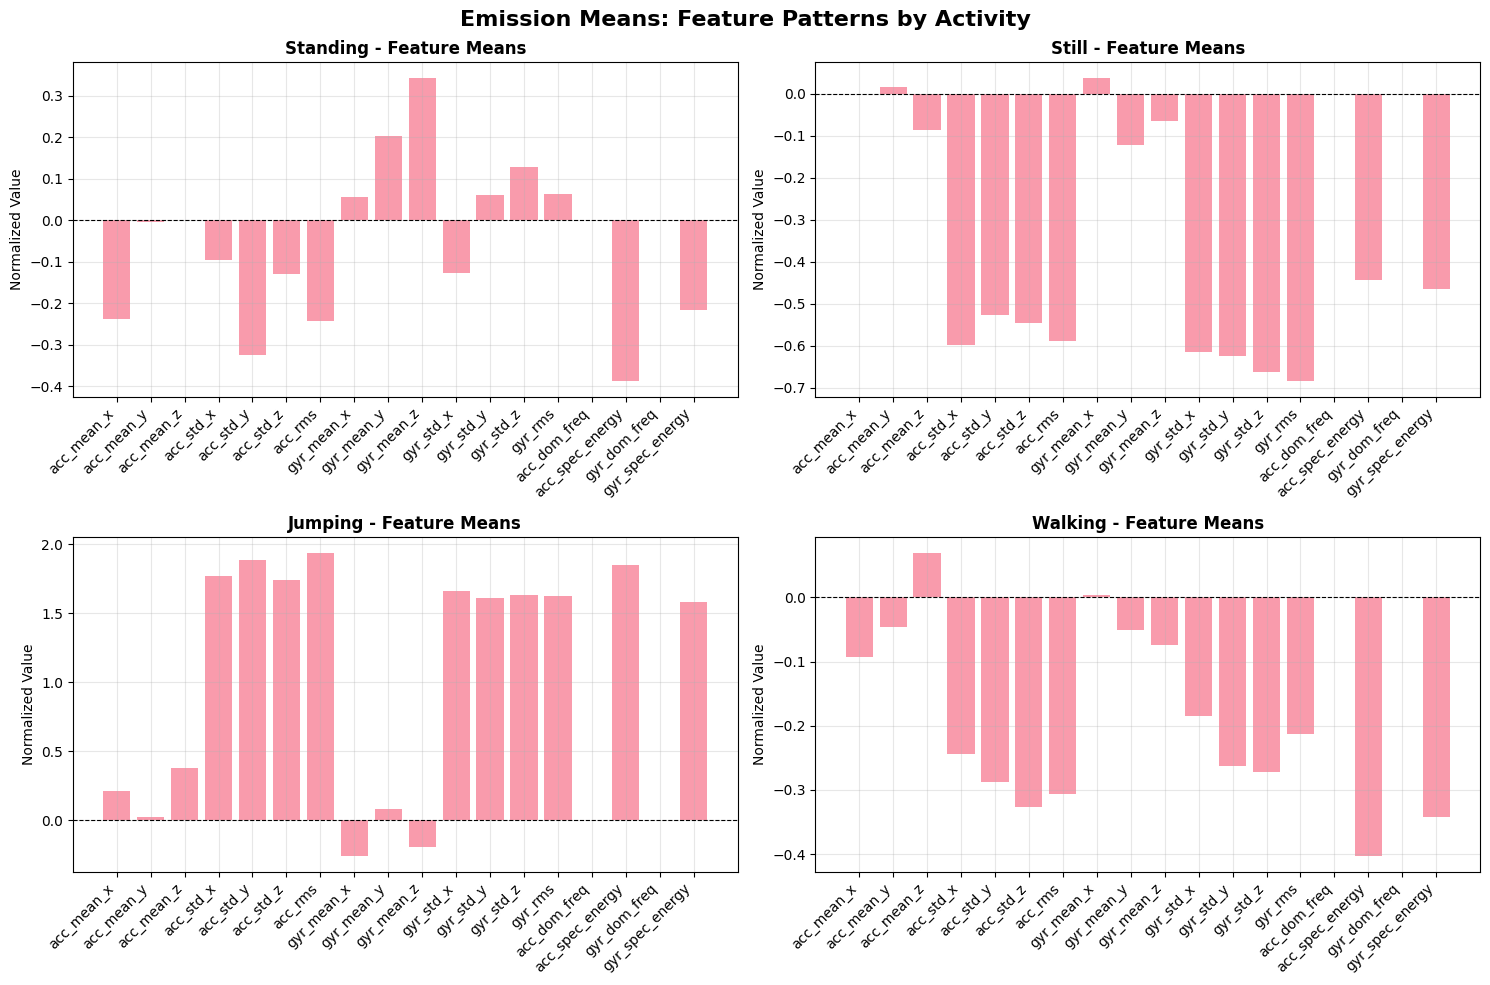

Feature patterns show discriminative characteristics per activity


In [65]:
# ============================================================================
#  Visualization - Feature Patterns
# ============================================================================
feature_names = [
    'acc_mean_x', 'acc_mean_y', 'acc_mean_z',
    'acc_std_x', 'acc_std_y', 'acc_std_z', 'acc_rms',
    'gyr_mean_x', 'gyr_mean_y', 'gyr_mean_z',
    'gyr_std_x', 'gyr_std_y', 'gyr_std_z', 'gyr_rms',
    'acc_dom_freq', 'acc_spec_energy',
    'gyr_dom_freq', 'gyr_spec_energy'
]

plt.figure(figsize=(15, 10))
for i, activity in enumerate(activities):
    plt.subplot(2, 2, i+1)
    plt.bar(range(len(feature_names)), hmm.means[i], alpha=0.7)
    plt.title(f'{activity.capitalize()} - Feature Means', fontweight='bold')
    plt.ylabel('Normalized Value')
    plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

plt.suptitle('Emission Means: Feature Patterns by Activity', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Feature patterns show discriminative characteristics per activity")


Example: Viterbi Decoding on Test Sequence


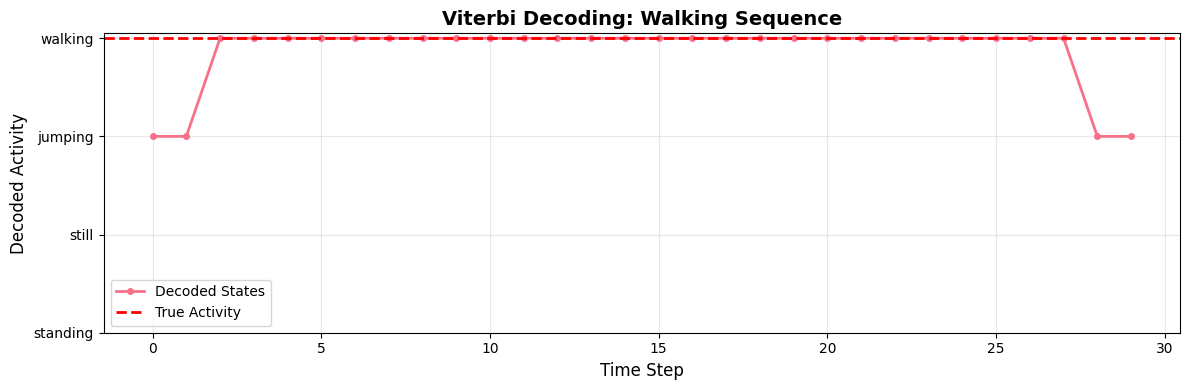

True activity: walking (state 3)
Majority decoded: walking (state 3)
Decoding confidence: 0.867
State distribution: {'standing': np.int64(0), 'still': np.int64(0), 'jumping': np.int64(4), 'walking': np.int64(26)}

HMM TRAINING AND EVALUATION COMPLETE


In [66]:
# ============================================================================
#  Example Viterbi Decoding
# ============================================================================
print("\nExample: Viterbi Decoding on Test Sequence")

test_activity = 'walking'
if test_activity in test_features and len(test_features[test_activity]) >= 30:
    test_sequence = test_features[test_activity][:30]
    true_state = activity_to_state[test_activity]

    decoded_states = hmm.viterbi(test_sequence)

    plt.figure(figsize=(12, 4))
    plt.plot(decoded_states, 'o-', linewidth=2, markersize=4, label='Decoded States')
    plt.axhline(y=true_state, color='red', linestyle='--', linewidth=2, label='True Activity')
    plt.yticks(range(4), activities)
    plt.title(f'Viterbi Decoding: {test_activity.capitalize()} Sequence',
              fontsize=14, fontweight='bold')
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('Decoded Activity', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    state_counts = np.bincount(decoded_states, minlength=4)
    majority_state = np.argmax(state_counts)
    confidence = state_counts[majority_state] / len(decoded_states)

    print(f"True activity: {test_activity} (state {true_state})")
    print(f"Majority decoded: {activities[majority_state]} (state {majority_state})")
    print(f"Decoding confidence: {confidence:.3f}")
    print(f"State distribution: {dict(zip(activities, state_counts))}")
else:
    print(f"Insufficient test data for {test_activity}")

print("\n" + "="*72)
print("HMM TRAINING AND EVALUATION COMPLETE")
print("="*72)